In [5]:
DRIVE_DATASET_DIR = r"C:\Users\MY PC\Downloads\Data 3 - Copy-20251202T185453Z-1-001\Data 3 - Copy"


In [6]:
!ls -la "{DRIVE_DATASET_DIR}" || echo "Dataset folder not found: {DRIVE_DATASET_DIR}"


"Dataset folder not found: C:\Users\MY PC\Downloads\Data 3 - Copy-20251202T185453Z-1-001\Data 3 - Copy"


'ls' is not recognized as an internal or external command,
operable program or batch file.


LOADING MODEL
✓ Model loaded from: C:\Users\MY PC\OneDrive\Desktop\Yolo medium 3 classes\best.pt
Model type: classify
Model was trained on 3 classes

PREPARING TEST DATA
Found 3 class folders in test path:
  - cardboard: 1172 images
  - glass: 2174 images
  - plastic: 1167 images

✓ Test has 3 class folders (as expected).

Using model.names (model was trained on 3 classes).

✓ Prepared 4513 total images for testing
✓ Created data.yaml at: C:\Users\MY PC\OneDrive\Desktop\Yolo medium 3 classes\temp_test_data\data.yaml

RUNNING MODEL EVALUATION
Testing on 3 classes: cardboard, glass, plastic
Ultralytics 8.3.235  Python-3.11.1 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4080, 16376MiB)
YOLO11m-cls summary (fused): 57 layers, 10,345,475 parameters, 0 gradients, 39.3 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 48.46.3 MB/s, size: 188.1 KB)
val: Scanning C:\Users\MY PC\OneDrive\Desktop\Yolo medium 3 classes\temp_test_data\test... 4513 images, 0 corrupt: 100% ━━━━━━━━━━━━ 4513/4513

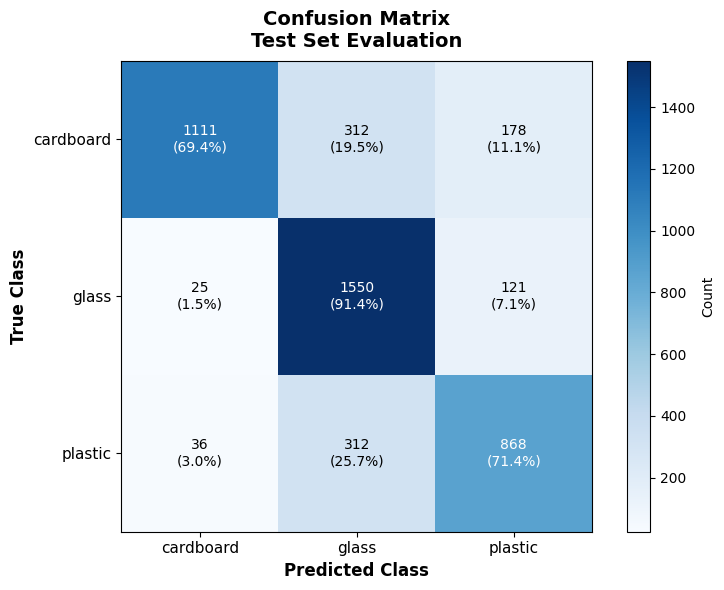

✓ Saved: confusion_matrix_normalized.png


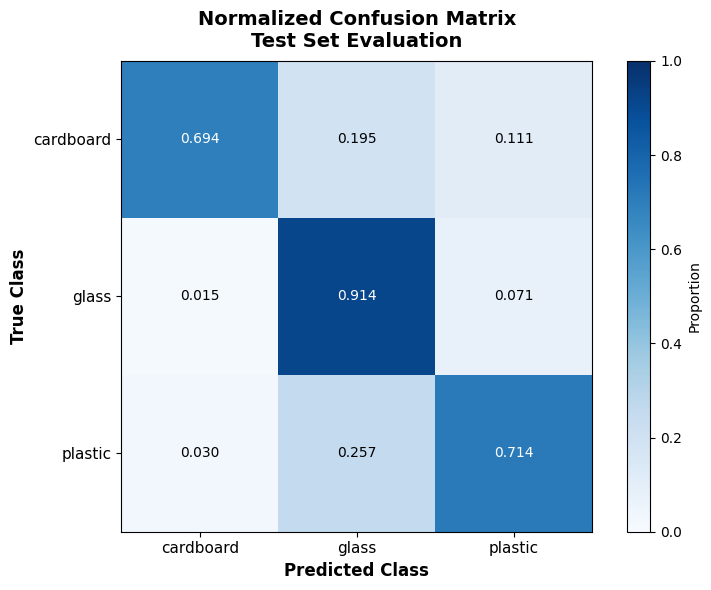

✓ Saved: metrics_comparison.png


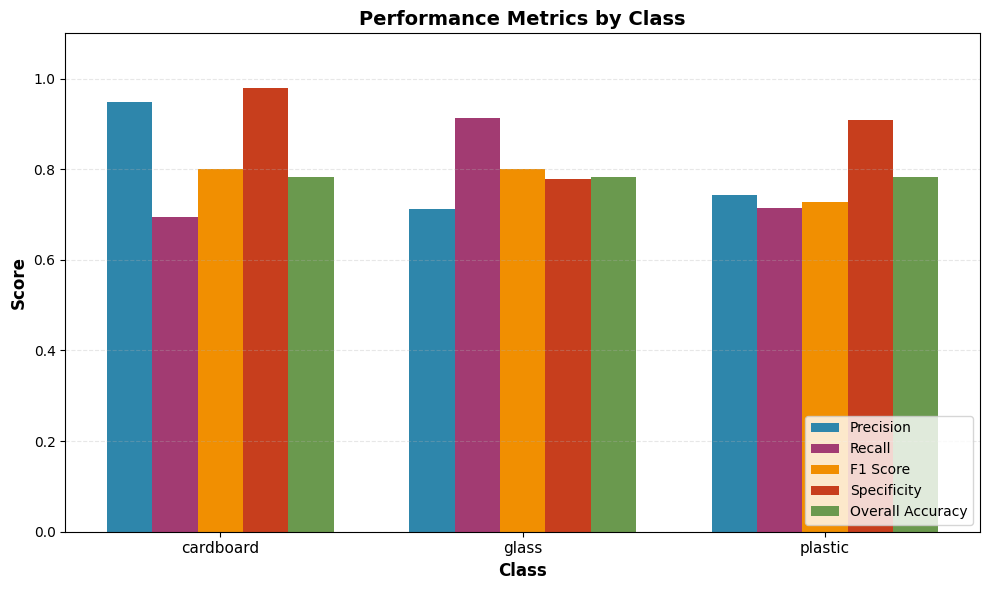


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

   cardboard     0.9480    0.6939    0.8013      1601
       glass     0.7130    0.9139    0.8010      1696
     plastic     0.7438    0.7138    0.7285      1216

    accuracy                         0.7820      4513
   macro avg     0.8016    0.7739    0.7769      4513
weighted avg     0.8046    0.7820    0.7816      4513


SUMMARY TABLE
Class           Samples    Precision    Recall       F1           Specificity 
--------------------------------------------------------------------------------
cardboard       1601       0.9480       0.6939       0.8013       0.9791      
glass           1696       0.7130       0.9139       0.8010       0.7785      
plastic         1216       0.7438       0.7138       0.7285       0.9093      
--------------------------------------------------------------------------------
MACRO AVG       4513       0.8016       0.7739       0.7769       0.8890      

✓ EVALUATION C

In [1]:
# YOLO Model Evaluation - Adapted for 3 classes
# ================================================================
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from ultralytics import YOLO
import yaml
import shutil
from pathlib import Path

MODEL_PATH = r"C:\Users\MY PC\OneDrive\Desktop\Yolo medium 3 classes\best.pt"   # <-- your model or .pt/.pth file
TEST_DATA_PATH = r"C:\Users\MY PC\OneDrive\Desktop\Yolo medium 3 classes\val"  # <-- test folders arranged by class

REQUIRED_NUM_CLASSES = 3

# -------------------------
# Load model
# -------------------------
print("="*60)
print("LOADING MODEL")
print("="*60)
model = YOLO(MODEL_PATH)
print(f"✓ Model loaded from: {MODEL_PATH}")
print(f"Model type: {model.task}")
print(f"Model was trained on {len(model.names)} classes")
print("="*60)

# -------------------------
# Prepare test classes (folders)
# -------------------------
print("\n" + "="*60)
print("PREPARING TEST DATA")
print("="*60)

test_classes = sorted([d for d in os.listdir(TEST_DATA_PATH)
                       if os.path.isdir(os.path.join(TEST_DATA_PATH, d))])

print(f"Found {len(test_classes)} class folders in test path:")
for cls in test_classes:
    cls_path = os.path.join(TEST_DATA_PATH, cls)
    num_images = len([f for f in os.listdir(cls_path)
                      if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
    print(f"  - {cls}: {num_images} images")

# -------------------------
# Validate number of classes
# -------------------------
if len(test_classes) != REQUIRED_NUM_CLASSES:
    print(f"\n⚠ WARNING: Found {len(test_classes)} test class folders but REQUIRED_NUM_CLASSES={REQUIRED_NUM_CLASSES}.")
    print("Make sure your test folders contain exactly the 3 classes you want to evaluate.")
else:
    print(f"\n✓ Test has {REQUIRED_NUM_CLASSES} class folders (as expected).")

# Use model.names as authoritative if it has 3 names
if len(model.names) == REQUIRED_NUM_CLASSES:
    print("\nUsing model.names (model was trained on 3 classes).")
    class_names = [model.names[i] for i in range(REQUIRED_NUM_CLASSES)]
else:
    # fallback: use folder names but warn user to ensure mapping aligns with training
    print("\n⚠ Model was NOT trained on 3 classes.")
    print(f"Model has {len(model.names)} names: {model.names}")
    print("Using test folder names as class_names — BUT ensure these match the class indices the model was trained on.")
    class_names = test_classes.copy()

num_classes = len(class_names)

# -------------------------
# Create temp directory (YOLO val expects a dataset structure)
# -------------------------
temp_dir = r"C:\Users\MY PC\OneDrive\Desktop\Yolo medium 3 classes\temp_test_data"
if os.path.exists(temp_dir):
    shutil.rmtree(temp_dir)
test_dir = os.path.join(temp_dir, "test")
os.makedirs(test_dir, exist_ok=True)

total_images = 0
for cls in test_classes:
    src_dir = os.path.join(TEST_DATA_PATH, cls)
    dst_dir = os.path.join(test_dir, cls)
    os.makedirs(dst_dir, exist_ok=True)
    for img_file in os.listdir(src_dir):
        if img_file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            shutil.copy2(os.path.join(src_dir, img_file), os.path.join(dst_dir, img_file))
            total_images += 1

print(f"\n✓ Prepared {total_images} total images for testing")

# -------------------------
# Create data.yaml (val -> test)
# -------------------------
data_config = {
    'path': temp_dir,
    'train': 'test',
    'val': 'test',
    'nc': num_classes,
    'names': class_names
}
data_yaml_path = os.path.join(temp_dir, 'data.yaml')
with open(data_yaml_path, 'w') as f:
    yaml.dump(data_config, f)
print(f"✓ Created data.yaml at: {data_yaml_path}")
print("="*60)

# -------------------------
# Run evaluation
# -------------------------
print("\n" + "="*60)
print("RUNNING MODEL EVALUATION")
print("="*60)
print(f"Testing on {num_classes} classes: {', '.join(class_names)}")
results = model.val(data=data_yaml_path, split="val", imgsz=224, save=False, plots=False)
print("✓ Evaluation complete!")
print("="*60)

# -------------------------
# Extract confusion matrix
# -------------------------
if not hasattr(results, 'confusion_matrix') or results.confusion_matrix is None:
    print("\n⚠  Confusion matrix not available in results")
    if hasattr(results, 'top1'):
        print(f"Top-1 Accuracy: {results.top1:.4f}")
    if hasattr(results, 'top5'):
        print(f"Top-5 Accuracy: {results.top5:.4f}")
    # clean up and exit
    if os.path.exists(temp_dir):
        shutil.rmtree(temp_dir)
    exit()

cm = results.confusion_matrix.matrix.astype(int)

# Trim/pad to expected shape if necessary
if cm.shape[0] != num_classes or cm.shape[1] != num_classes:
    print(f"\n⚠ Confusion matrix shape {cm.shape} does not match expected ({num_classes},{num_classes}).")
    minr = min(cm.shape[0], num_classes)
    minc = min(cm.shape[1], num_classes)
    cm = cm[:minr, :minc]
    # If smaller (unlikely) pad zeros
    if cm.shape[0] < num_classes or cm.shape[1] < num_classes:
        cm_padded = np.zeros((num_classes, num_classes), dtype=int)
        cm_padded[:cm.shape[0], :cm.shape[1]] = cm
        cm = cm_padded
    print(f"Adjusted confusion matrix to shape {cm.shape}")

print("\n" + "="*60)
print("TEST RESULTS")
print("="*60)
print(f"Classes evaluated: {class_names}")
print(f"Confusion matrix shape: {cm.shape}")
print(f"\nConfusion Matrix:\n{cm}")

# -------------------------
# Metrics calculation
# -------------------------
TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP

precision = np.divide(TP, (TP + FP), out=np.zeros_like(TP, dtype=float), where=(TP + FP) != 0)
recall = np.divide(TP, (TP + FN), out=np.zeros_like(TP, dtype=float), where=(TP + FN) != 0)
f1 = np.divide(2 * precision * recall, (precision + recall), out=np.zeros_like(precision, dtype=float), where=(precision + recall) != 0)
accuracy = np.sum(TP) / np.sum(cm) if np.sum(cm) > 0 else 0

specificity = np.zeros(num_classes)
for i in range(num_classes):
    tn = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
    fp = np.sum(cm[:, i]) - cm[i, i]
    specificity[i] = tn / (tn + fp) if (tn + fp) > 0 else 0

print("\n" + "="*60)
print("OVERALL METRICS")
print("="*60)
print(f"Overall Accuracy:      {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Macro Avg Precision:   {np.mean(precision):.4f} ({np.mean(precision)*100:.2f}%)")
print(f"Macro Avg Recall:      {np.mean(recall):.4f} ({np.mean(recall)*100:.2f}%)")
print(f"Macro Avg F1 Score:    {np.mean(f1):.4f} ({np.mean(f1)*100:.2f}%)")
print(f"Macro Avg Specificity: {np.mean(specificity):.4f} ({np.mean(specificity)*100:.2f}%)")
print(f"Total samples tested:  {np.sum(cm)}")

# -------------------------
# Per-class reporting
# -------------------------
print("\n" + "="*60)
print("PER-CLASS METRICS")
print("="*60)
for i, name in enumerate(class_names):
    print(f"\n{name.upper()}:")
    print(f"  Samples:      {np.sum(cm[i, :])} images")
    print(f"  Precision:    {precision[i]:.4f} ({precision[i]*100:.2f}%)")
    print(f"  Recall:       {recall[i]:.4f} ({recall[i]*100:.2f}%)")
    print(f"  F1 Score:     {f1[i]:.4f} ({f1[i]*100:.2f}%)")
    print(f"  Specificity:  {specificity[i]:.4f} ({specificity[i]*100:.2f}%)")

# -------------------------
# Plot confusion matrix (optimized for 3 classes)
# -------------------------
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, cmap="Blues", interpolation='nearest')
ax.set_title("Confusion Matrix\nTest Set Evaluation", fontsize=14, fontweight='bold', pad=10)
ax.set_xlabel("Predicted Class", fontsize=12, fontweight='bold')
ax.set_ylabel("True Class", fontsize=12, fontweight='bold')
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels(class_names, fontsize=11)
ax.set_yticklabels(class_names, fontsize=11)

for i in range(num_classes):
    for j in range(num_classes):
        total_in_class = np.sum(cm[i, :])
        percentage = (cm[i, j] / total_in_class * 100) if total_in_class > 0 else 0
        text_color = "white" if cm[i, j] > cm.max() / 2 else "black"
        ax.text(j, i, f"{cm[i, j]}\n({percentage:.1f}%)", ha="center", va="center", color=text_color, fontsize=10)

plt.colorbar(im, ax=ax, label='Count')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: confusion_matrix.png")
plt.show()

# -------------------------
# Normalized confusion matrix
# -------------------------
with np.errstate(all='ignore'):
    cm_normalized = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])
    cm_normalized = np.nan_to_num(cm_normalized)

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm_normalized, cmap="Blues", interpolation='nearest', vmin=0, vmax=1)
ax.set_title("Normalized Confusion Matrix\nTest Set Evaluation", fontsize=14, fontweight='bold', pad=10)
ax.set_xlabel("Predicted Class", fontsize=12, fontweight='bold')
ax.set_ylabel("True Class", fontsize=12, fontweight='bold')
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels(class_names, fontsize=11)
ax.set_yticklabels(class_names, fontsize=11)

for i in range(num_classes):
    for j in range(num_classes):
        text_color = "white" if cm_normalized[i, j] > 0.5 else "black"
        ax.text(j, i, f"{cm_normalized[i, j]:.3f}", ha="center", va="center", color=text_color, fontsize=10)

plt.colorbar(im, ax=ax, label='Proportion')
plt.tight_layout()
plt.savefig('confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
print("✓ Saved: confusion_matrix_normalized.png")
plt.show()

# -------------------------
# Metrics comparison bar chart
# -------------------------
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(num_classes)
width = 0.15

bars1 = ax.bar(x - 2*width, precision, width, label='Precision', color='#2E86AB')
bars2 = ax.bar(x - width, recall, width, label='Recall', color='#A23B72')
bars3 = ax.bar(x, f1, width, label='F1 Score', color='#F18F01')
bars4 = ax.bar(x + width, specificity, width, label='Specificity', color='#C73E1D')
bars5 = ax.bar(x + 2*width, [accuracy]*num_classes, width, label='Overall Accuracy', color='#6A994E')

ax.set_xlabel('Class', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Performance Metrics by Class', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_names, fontsize=11)
ax.legend(loc='lower right', fontsize=10)
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Saved: metrics_comparison.png")
plt.show()

# -------------------------
# Classification report
# -------------------------
y_true = []
y_pred = []
for i in range(num_classes):
    for j in range(num_classes):
        count = int(cm[i][j])
        if count > 0:
            y_true.extend([i] * count)
            y_pred.extend([j] * count)

if len(y_true) > 0:
    print("\n" + "="*60)
    print("DETAILED CLASSIFICATION REPORT")
    print("="*60)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0))

# -------------------------
# Summary table
# -------------------------
print("\n" + "="*60)
print("SUMMARY TABLE")
print("="*60)
print(f"{'Class':<15} {'Samples':<10} {'Precision':<12} {'Recall':<12} {'F1':<12} {'Specificity':<12}")
print("-" * 80)
for i, name in enumerate(class_names):
    samples = np.sum(cm[i, :])
    print(f"{name:<15} {samples:<10} {precision[i]:<12.4f} {recall[i]:<12.4f} {f1[i]:<12.4f} {specificity[i]:<12.4f}")
print("-" * 80)
print(f"{'MACRO AVG':<15} {np.sum(cm):<10} {np.mean(precision):<12.4f} {np.mean(recall):<12.4f} {np.mean(f1):<12.4f} {np.mean(specificity):<12.4f}")
print("="*60)

# Final summary
print("\n" + "="*60)
print("✓ EVALUATION COMPLETE!")
print("="*60)
print(f"Model:                 {MODEL_PATH}")
print(f"Test data:             {TEST_DATA_PATH}")
print(f"Classes:               {', '.join(class_names)}")
print(f"Total images tested:   {np.sum(cm)}")
print(f"Overall Accuracy:      {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Macro Avg F1 Score:    {np.mean(f1):.4f} ({np.mean(f1)*100:.2f}%)")
print("="*60)

# Cleanup
if os.path.exists(temp_dir):
    shutil.rmtree(temp_dir)
    print("\n✓ Cleaned up temporary files")